# 목차
> ## 라이브러리 import
> ## 데이터 로드 및 전처리
> ## 모델 설계 및 학습
> ## 테스트
> ## 회고

## 필요한 라이브러리를 불러옵니다.

In [67]:
import datetime as dt
from pathlib import Path
import os
import time
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## 데이터를 불러옵니다.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* 예제와는 다른 타입의 시간 자료네요 보기 좋게 바꿔보겠습니다.

In [3]:
tm = time.localtime(965333392)
string = time.strftime('%Y-%m-%d %I:%M:%S %p', tm)
print(string)

2000-08-03 08:09:52 PM


* 위에서 만든 코드로 함수를 만들어 데이터 프레임에 적용시켜보겠습니다.

In [4]:
def timestamp(tm):
    tm = time.localtime(tm)
    string = time.strftime('%Y-%m-%d %I:%M:%S %p', tm)
    return string

In [5]:
timestamp(965333392)

'2000-08-03 08:09:52 PM'

In [6]:
data['time'] = data['Time'].apply(timestamp)

* 적용했고, 확인은 밑에서 하겠습니다.

* 많이 고민했던 부분인데, 세션아이디가 없어서 어떻게 만들지 고민하다 클릭후 다음 클릭까지 30분 이상이 지나면 다른 세션으로 만들겠습니다.

In [7]:
a = list(data['Time'])
b = [0]
for i, tm in enumerate(a):
    if i == len(a)-1:
        break
    elif  abs(a[i] - a[i+1]) > 1800:
        b.append(i+1)

In [8]:
len(a)

1000209

* 세션아이디를 만들기위해 다음 세션으로 바뀌는 지점을 b라는 리스트로 만들었습니다.

In [65]:
b[:10]

[0, 40, 53, 182, 233, 254, 452, 523, 554, 692]

In [10]:
len(b)

24309

In [11]:
b.append(1000209)

In [12]:
data['id'] = np.arange(1, 1000210)

* 계산을 편하게 하기위해 새로 인덱싱한 id란 컬럼을 만들었습니다.

In [13]:
data.head(45)

,UserId,ItemId,Rating,Time,time,id
31,1,3186,4,978300019,2000-12-31 10:00:19 PM,1
22,1,1270,5,978300055,2000-12-31 10:00:55 PM,2
27,1,1721,4,978300055,2000-12-31 10:00:55 PM,3
37,1,1022,5,978300055,2000-12-31 10:00:55 PM,4
24,1,2340,3,978300103,2000-12-31 10:01:43 PM,5
36,1,1836,5,978300172,2000-12-31 10:02:52 PM,6
3,1,3408,4,978300275,2000-12-31 10:04:35 PM,7
7,1,2804,5,978300719,2000-12-31 10:11:59 PM,8
47,1,1207,4,978300719,2000-12-31 10:11:59 PM,9
0,1,1193,5,978300760,2000-12-31 10:12:40 PM,10


* 아까 적용했던 타임스탬프 함수도 잘 나왔군요

In [14]:
data.tail()

,UserId,ItemId,Rating,Time,time,id
1000019,6040,2917,4,997454429,2001-08-10 02:40:29 PM,1000205
999988,6040,1921,4,997454464,2001-08-10 02:41:04 PM,1000206
1000172,6040,1784,3,997454464,2001-08-10 02:41:04 PM,1000207
1000167,6040,161,3,997454486,2001-08-10 02:41:26 PM,1000208
1000042,6040,1221,4,998315055,2001-08-20 01:44:15 PM,1000209


* b를 만들때 마지막을 고려하지 않아 마지막 인덱스만 추가로 넣기 위해 확인해보았습니다.

In [15]:
c = [i for i in range(24309)]

In [16]:
data["SessionId_1"] = pd.cut(data["id"], b, right=True, labels=c)

* 이 부분에 시행착오가 많았는데 밑에 회고에 남기겠습니다. cut 함수를 이용해 세션아이디를 만들었습니다.

In [17]:
data.head(10)

,UserId,ItemId,Rating,Time,time,id,SessionId_1
31,1,3186,4,978300019,2000-12-31 10:00:19 PM,1,0
22,1,1270,5,978300055,2000-12-31 10:00:55 PM,2,0
27,1,1721,4,978300055,2000-12-31 10:00:55 PM,3,0
37,1,1022,5,978300055,2000-12-31 10:00:55 PM,4,0
24,1,2340,3,978300103,2000-12-31 10:01:43 PM,5,0
36,1,1836,5,978300172,2000-12-31 10:02:52 PM,6,0
3,1,3408,4,978300275,2000-12-31 10:04:35 PM,7,0
7,1,2804,5,978300719,2000-12-31 10:11:59 PM,8,0
47,1,1207,4,978300719,2000-12-31 10:11:59 PM,9,0
0,1,1193,5,978300760,2000-12-31 10:12:40 PM,10,0


* 데이터의 타입들을 확인해 보겠습니다.

In [18]:
data.dtypes

UserId            int32
ItemId            int32
Rating            int32
Time              int64
time             object
id                int64
SessionId_1    category
dtype: object

* 세션타입이 처음보는 카테고리 타입이네요. 이 부분때문에 고생을 많이 했습니다.

* 클리닝 함수를 사용하기 위해 정수로 바꿔줘보겠습니다.

In [19]:
SessionId_list = list(data["SessionId_1"])

In [20]:
data['SessionId'] = SessionId_list

In [21]:
data.dtypes

UserId            int32
ItemId            int32
Rating            int32
Time              int64
time             object
id                int64
SessionId_1    category
SessionId         int64
dtype: object

* 정수로 잘 적용이 되었습니다.

In [22]:
del data['SessionId_1']

* 카테고리타입의 세션아이디는 필요 없어 제거했습니다.

### 데이터 분석

In [23]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(24309, 3706)

* 세션아이디와 아이템아이디의 유니크한 개수입니다.

In [24]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         40
1         13
2        129
3         51
4         21
        ... 
24304      7
24305     14
24306      1
24307     21
24308      1
Length: 24309, dtype: int64

* 세션의 길이입니다.

In [25]:
session_length.min(), session_length.max()

(1, 1193)

* 세션길이의 최솟값, 최댓값입니다. 1193이란 길이는 좀 특이하네요.

In [26]:
session_length.quantile(0.9)

124.0

* 90%의 데이터는 124의 길이까지인데 1193이란 길이는 많이 특이해서 직접 확인해보겠습니다.

In [27]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session].head(30)

,UserId,ItemId,Rating,Time,time,id,SessionId
637775,3841,1480,3,965995059,2000-08-11 11:57:39 AM,637583,15852
637808,3841,969,5,965995059,2000-08-11 11:57:39 AM,637584,15852
638269,3841,858,5,965995059,2000-08-11 11:57:39 AM,637585,15852
638716,3841,2019,5,965995059,2000-08-11 11:57:39 AM,637586,15852
638733,3841,1221,5,965995059,2000-08-11 11:57:39 AM,637587,15852
637782,3841,2288,2,965995116,2000-08-11 11:58:36 AM,637588,15852
638122,3841,1304,5,965995116,2000-08-11 11:58:36 AM,637589,15852
638172,3841,1196,3,965995116,2000-08-11 11:58:36 AM,637590,15852
638266,3841,1387,5,965995116,2000-08-11 11:58:36 AM,637591,15852
638310,3841,2366,5,965995116,2000-08-11 11:58:36 AM,637592,15852


* 짧은 시간에 사람이 한것이라 믿을수 없는 속도입니다.

In [28]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_9 = length_percent_cumsum[length_percent_cumsum < 0.9]

length_percent_cumsum_9

1      0.282982
2      0.386935
3      0.438850
4      0.472294
5      0.499733
         ...   
119    0.895059
120    0.896211
121    0.897281
122    0.898433
123    0.899790
Length: 123, dtype: float64

* 90%의 자료만 뽑아 보았고, 이를 시각화해보겠습니다.

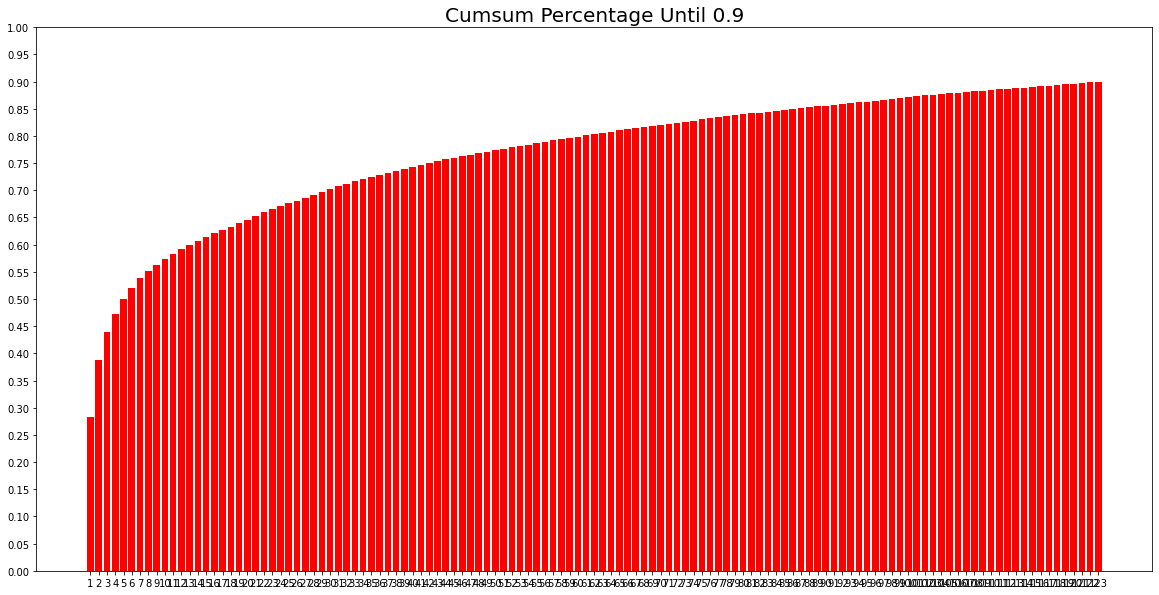

In [66]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_9.index,
        height=length_percent_cumsum_9, color='red')
plt.xticks(length_percent_cumsum_9.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.9', size=20)
plt.show()

In [30]:
oldest, latest = data['time'].min(), data['time'].max()
print(oldest) 
print(latest)

2000-04-25 11:05:32 PM
2003-02-28 12:51:39 AM


* 가장 오래된 시간과 가장 최근 시간입니다. 3년안에 모두 이루어졌네요. 그대로 사용하겠습니다.

In [31]:
type(latest)

str

* 타입이 str이라 연산시 귀찮을것 같아 Time(초)으로 계산하겠습니다.

### 데이터 크리닝

In [32]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

* 너무 짧아도 안좋고 길어도 안좋아서 데이터 줄여보겠습니다.

In [33]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,time,id,SessionId
31,1,3186,4,978300019,2000-12-31 10:00:19 PM,1,0
22,1,1270,5,978300055,2000-12-31 10:00:55 PM,2,0
27,1,1721,4,978300055,2000-12-31 10:00:55 PM,3,0
37,1,1022,5,978300055,2000-12-31 10:00:55 PM,4,0
24,1,2340,3,978300103,2000-12-31 10:01:43 PM,5,0
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 02:39:58 PM,1000204,24307
1000019,6040,2917,4,997454429,2001-08-10 02:40:29 PM,1000205,24307
999988,6040,1921,4,997454464,2001-08-10 02:41:04 PM,1000206,24307
1000172,6040,1784,3,997454464,2001-08-10 02:41:04 PM,1000207,24307


* 만개정도 줄었네요.

### 데이터 스플릿

In [34]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [35]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [36]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["time"].min()}\n'
          f'\t Last Time : {data["time"].max()}\n')

In [37]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 983248
	 Sessions: 16696
	 Items: 3405
	 First Time : 2000-04-25 11:05:32 PM
	 Last Time : 2002-08-12 12:51:02 AM

* valid Set Stats Info
	 Events: 4766
	 Sessions: 333
	 Items: 1851
	 First Time : 2002-08-13 04:27:51 PM
	 Last Time : 2002-11-20 12:53:08 AM

* test Set Stats Info
	 Events: 4684
	 Sessions: 383
	 Items: 1803
	 First Time : 2002-11-21 01:02:06 AM
	 Last Time : 2003-02-28 05:49:50 PM



* 3가지 데이터셋으로 잘 나누어졌습니다.

In [38]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [39]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

* 나눈 데이터를 다시 인덱싱하고, 저장했습니다.

In [40]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

* 데이터셋을 만들 함수입니다.

In [41]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail(10)

,UserId,ItemId,Rating,Time,time,id,SessionId,item_idx
999905,6040,953,5,997454160,2001-08-10 02:36:00 PM,1000199,24307,586
1000169,6040,2725,4,997454180,2001-08-10 02:36:20 PM,1000200,24307,371
1000105,6040,1673,4,997454212,2001-08-10 02:36:52 PM,1000201,24307,458
1000118,6040,457,4,997454349,2001-08-10 02:39:09 PM,1000202,24307,131
1000119,6040,3671,4,997454367,2001-08-10 02:39:27 PM,1000203,24307,180
999923,6040,232,5,997454398,2001-08-10 02:39:58 PM,1000204,24307,1097
1000019,6040,2917,4,997454429,2001-08-10 02:40:29 PM,1000205,24307,1247
999988,6040,1921,4,997454464,2001-08-10 02:41:04 PM,1000206,24307,370
1000172,6040,1784,3,997454464,2001-08-10 02:41:04 PM,1000207,24307,89
1000167,6040,161,3,997454486,2001-08-10 02:41:26 PM,1000208,24307,464


* 잘 적용이 되었습니다.

### 모델 설계

In [43]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [45]:
iter_ex = iter(tr_data_loader)

In [46]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 40 53 65]
Label Item Idx are :       [ 1 41 54 62]
Previous Masked Input Idx are []


* 라벨 아이템 인덱싱이 마지막이 66이 아니라 62입니다. 아직 원인을 모르겠습니다.

In [47]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [48]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [56]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
args_1 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args_2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

* 여기서도 조원들과 퍼실님의 도움을 받았는데, batch_size를 생각없이 그대로 썼는데, 데이터량보다 많으면 에러가 났습니다.

In [50]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3405)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    518550    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3405)               173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


* 모델 시각화

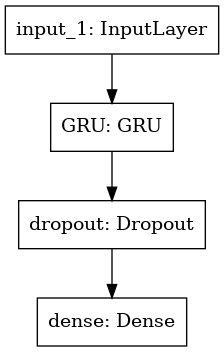

In [51]:
plot_model(model)

In [52]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### 모델 학습

In [53]:
train_model(model, args)

Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.04] 

	 - Recall@20 epoch 1: 0.075521
	 - MRR@20    epoch 1: 0.014057



Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.67] 

	 - Recall@20 epoch 2: 0.091146
	 - MRR@20    epoch 2: 0.019200



Evaluation:  26%|██▋       | 9/34 [00:06<00:19,  1.30it/s]

	 - Recall@20 epoch 3: 0.109375
	 - MRR@20    epoch 3: 0.023242



### 모델 테스트

In [54]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  33%|███▎      | 11/33 [00:08<00:16,  1.36it/s]

	 - Recall@20: 0.177557
	 - MRR@20: 0.059516



* 학습이 정상적으로 완료 되었는데, 성능은 별로인것 같습니다.

In [58]:
model = create_model(args_1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3405)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    518550    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3405)               173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model, args_1)

Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.08] 

	 - Recall@20 epoch 1: 0.065972
	 - MRR@20    epoch 1: 0.013307



Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.57] 

	 - Recall@20 epoch 2: 0.087674
	 - MRR@20    epoch 2: 0.024775



Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.63]  

	 - Recall@20 epoch 3: 0.107639
	 - MRR@20    epoch 3: 0.027504



Train:   0%|          | 0/7551 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.45] 

	 - Recall@20 epoch 4: 0.112847
	 - MRR@20    epoch 4: 0.028067



Evaluation:  26%|██▋       | 9/34 [00:06<00:19,  1.30it/s]

	 - Recall@20 epoch 5: 0.112847
	 - MRR@20    epoch 5: 0.030354



In [60]:
test_model(model, args_1, test)

Evaluation:  33%|███▎      | 11/33 [00:08<00:16,  1.37it/s]

	 - Recall@20: 0.182528
	 - MRR@20: 0.066130



* 학습수만 늘려봤는데 정확도가 조금 올랐습니다.

In [61]:
model = create_model(args_2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3405)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      518550    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3405)                173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


In [62]:
train_model(model, args_2)

Train:   0%|          | 0/15102 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.29]

	 - Recall@20 epoch 1: 0.120226
	 - MRR@20    epoch 1: 0.030041



Train:   0%|          | 0/15102 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.63]

	 - Recall@20 epoch 2: 0.133247
	 - MRR@20    epoch 2: 0.036246



Train:   0%|          | 0/15102 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.52]

	 - Recall@20 epoch 3: 0.140625
	 - MRR@20    epoch 3: 0.039253



Train:   0%|          | 0/15102 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.96]

	 - Recall@20 epoch 4: 0.142795
	 - MRR@20    epoch 4: 0.041262



Evaluation:  52%|█████▏    | 36/69 [00:14<00:12,  2.54it/s]

	 - Recall@20 epoch 5: 0.145833
	 - MRR@20    epoch 5: 0.041600



In [63]:
test_model(model, args_2, test)

Evaluation:  55%|█████▌    | 37/67 [00:14<00:11,  2.62it/s]

	 - Recall@20: 0.201436
	 - MRR@20: 0.065005



* batch를 줄이고 학습수도 올리니 정확도가 꽤 올랐습니다.

## 회고
> #### 세션 아이디를 만들때 처음에는 단순하게 반복문만 가지고 작업을 하다가 데이터 양이 너무 많아 반복문 하는데 시간이 너무 오래 걸려 효율적이지 못해 이런 함수가 없나 하다 cut 함수를 찾았습니다.
> #### 위의 cut 함수를 사용하면 자동으로 타입이 카테고리로 변경이 됩니다. 이게 문제가 되는 이유는 다시 인덱싱을 할때, 삭제된 숫자가 카테고리로 그대로 남아있어 데이터프레임에는 보이지 않지만 다시 인덱싱을 할때 남아있어 방해가 되었습니다.
> #### 그리고 batch사이즈를 2048로 처음 진행했었는데, val_data는 333개라 오류가 생겼는데 조원들과 퍼실님의 도움으로 살았습니다.
> #### 마지막으로 세션의 기준을 30분으로 잡았는데, 처음 1시간으로 잡으니 아이디가 달라도 같은 세션이 되는 경우가 생겼습니다. 이를 해결하기 위해 처음 groupby 를 사용해 카운팅하여 다시 인덱싱을 시도했는데 오류가 나왔습니다. 지금 생각해 보니 세션아이디의 타입이 카테고리여서 오류가 났나 생각이 듭니다. 
> #### 그래서 10분, 15분, 30분 이렇게 쪼개 보다 30분으로 나눴을때 조금 그래프가 좋다고 생각해서 30분으로 선택했습니다. 지금은 시간이 없어 못하지만 다음에 한번 아이디와 세션아이디로 groupby 함수를 통해 작업해보겠습니다.